In [43]:
import argparse
import time

import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split

import torch
from torch.autograd import Variable
from torch.utils.data import DataLoader

from model import MultiLayerPerceptron
from dataset import AdultDataset 
from util import *

import torch.utils.data as data
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from scipy.signal import savgol_filter



""" Adult income classification

In this project, I have built my own multilayer perceptron to do classification on the adult income dataset. 
Information on the dataset can be found here: http://www.cs.toronto.edu/~delve/data/adult/adultDetail.html

Goal: To predict the "income" field (>50k or <50k) based on the other fields in the dataset

"""
#SETTING PARAMETERS 
bs = 64 #batch size --> bs * iterations of N = approx. no.samples
lr = 1 #learning rate 
numepoch = 7
seed = 0
N = 10 #print accuracy after N batches 


In [44]:

# =================================== LOAD DATASET =========================================== #

data = pd.read_csv('adult.csv') #dataset is imported as a DataFrame object


In [45]:

# =================================== DATA VISUALIZATION =========================================== #

print(data.shape) #(48842,15)
print(data.columns) #(15)--> ['age','workclass',.......]

verbose_print(data) #(5,15) --> display 1st 5 rows (aka.samples) of data

income = pd.Index([">50K", "<=50K"]) #Index of incomes
data.income.value_counts() #No. of high income, No. of low income 


(48842, 15)
Index(['age', 'workclass', 'fnlwgt', 'education', 'educational-num',
       'marital-status', 'occupation', 'relationship', 'race', 'gender',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object')
   age  workclass  fnlwgt     education  educational-num      marital-status  \
0   25    Private  226802          11th                7       Never-married   
1   38    Private   89814       HS-grad                9  Married-civ-spouse   
2   28  Local-gov  336951    Assoc-acdm               12  Married-civ-spouse   
3   44    Private  160323  Some-college               10  Married-civ-spouse   
4   18          ?  103497  Some-college               10       Never-married   

          occupation relationship   race  gender  capital-gain  capital-loss  \
0  Machine-op-inspct    Own-child  Black    Male             0             0   
1    Farming-fishing      Husband  White    Male             0             0   
2    Prote

<=50K    37155
>50K     11687
Name: income, dtype: int64

In [46]:
# =================================== DATA CLEANING =========================================== #

# Missing values are indicated with the symbol "?" in the dataset. 

# Count how many "?" entries there are for each feature
col_names = data.columns
num_rows = data.shape[0]

for feature in col_names: 
    count = data[feature].isin(["?"]).sum() #sum the "?"s in the column  
    print("?s in", feature, ":", count)
    

    # Get rid of samples with 1 or more "?"  
    #loop through recursively, removing any rows with a "?"", starting from 1st col.
    data = data[data[feature] != "?"] 


?s in age : 0
?s in workclass : 2799
?s in fnlwgt : 0
?s in education : 0
?s in educational-num : 0
?s in marital-status : 0
?s in occupation : 10
?s in relationship : 0
?s in race : 0
?s in gender : 0
?s in capital-gain : 0
?s in capital-loss : 0
?s in hours-per-week : 0
?s in native-country : 811
?s in income : 0


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [47]:
# =================================== BALANCE DATASET =========================================== #

#Randomly drop samples from the overrepresented samples 

#Extract overrepresented data 
overrep = data.loc[data["income"] == "<=50K"] 
overrep = pd.DataFrame(overrep) #(34014,15) --> Convert to DataFrame object 
#underrep = 45222-34014 = (11208,15)

# Since min(n,m) = 11208, randomly remove 22806 (the difference) samples from <=50K samples so only 11208 <=50K samples remain      
overrepnew = overrep.sample(n = 11208, axis = 0 , random_state = seed) 

#Extract underrepresented data 
underrep = data.loc[data["income"] == ">50K"]
underrep = pd.DataFrame(underrep)

#Merge the overrep and underrep (now balanced)
data = pd.concat([overrepnew,underrep]) 
data = pd.DataFrame(data) #(22416,15) --> Overrep and underrep each equal (11208, 15)

income = pd.Index([">50K", "<=50K"]) #Index: No. of high income, No. of low income 
print(data.income.value_counts()) #Check updated numbers (they should be equal now)

>50K     11208
<=50K    11208
Name: income, dtype: int64


                age         fnlwgt  educational-num  capital-gain  \
count  22416.000000   22416.000000     22416.000000  22416.000000   
mean      40.329006  189366.055407        10.617684   2071.453828   
std       12.590194  104837.760612         2.586669  10532.427796   
min       17.000000   13492.000000         1.000000      0.000000   
25%       31.000000  117695.750000         9.000000      0.000000   

       capital-loss  hours-per-week  
count  22416.000000    22416.000000  
mean     123.980728       42.594040  
std      478.371045       11.832265  
min        0.000000        1.000000  
25%        0.000000       40.000000  
----- workclass -----
Private             15867
Self-emp-not-inc     1953
Local-gov            1615
Self-emp-inc         1157
State-gov             983
Federal-gov           836
Without-pay             5
Name: workclass, dtype: int64
----- race -----
White                 19704
Black                  1731
Asian-Pac-Islander      640
Amer-Indian-Eskimo    

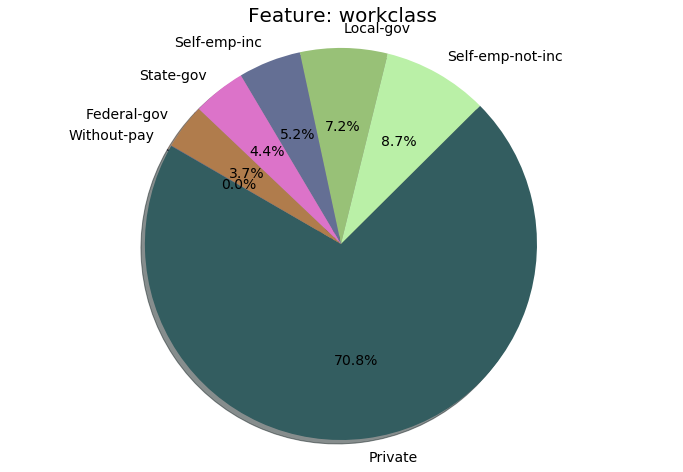

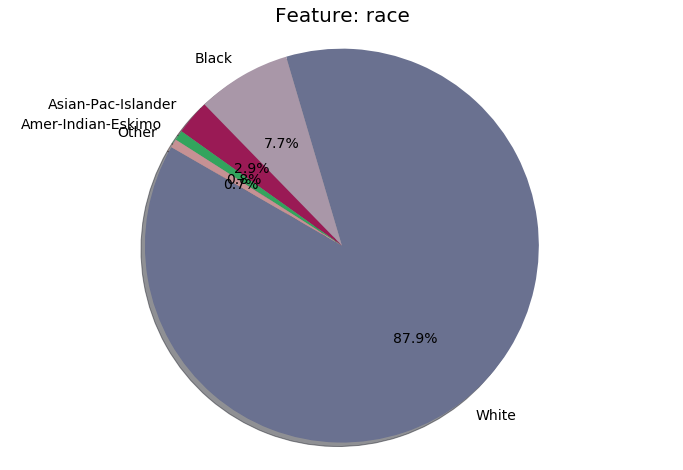

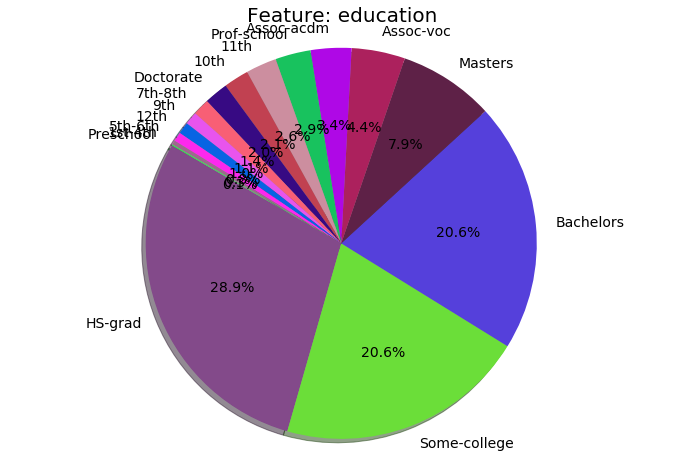

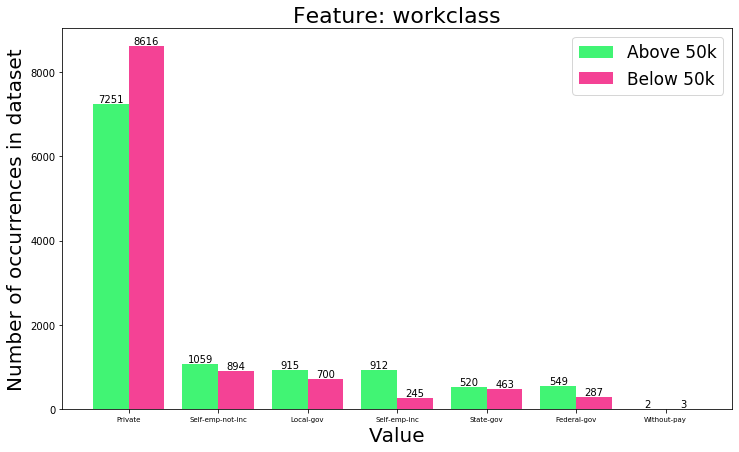

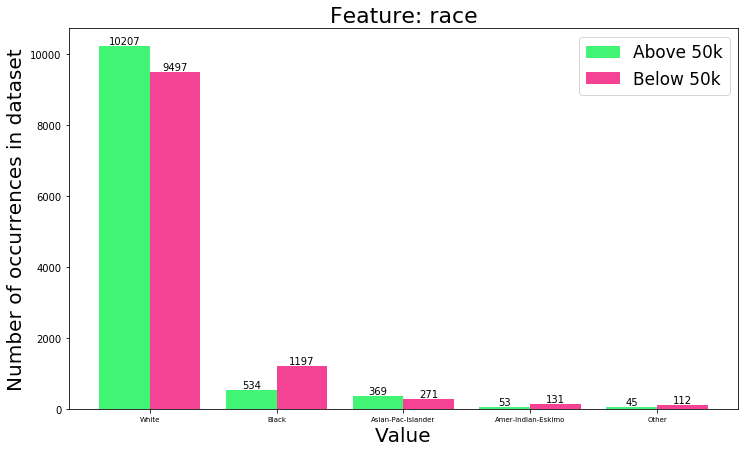

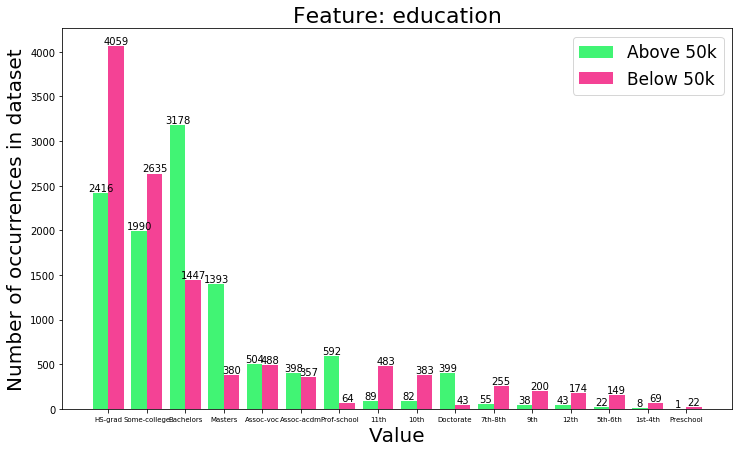

In [48]:
# =================================== DATA STATISTICS =========================================== #

# Our dataset contains both continuous and categorical features

# Print mean, variance of each column (of the continuous features)
verbose_print(data.describe()) 

categorical_feats = ['workclass', 'race', 'education', 'marital-status', 'occupation',
                    'relationship', 'gender', 'native-country', 'income']

#Check each possible value of a categorical feature and how often it occurs
for feature in categorical_feats:
    print("-----",feature,"-----")
    print(data[feature].value_counts()) # No.of each distinct feature/feature column


# Visualize first 3 features using pie and bar graphs
#Pie charts 
pie_chart(data, 'workclass')
pie_chart(data, 'race')
pie_chart(data, 'education')

#Bar graphs
binary_bar_chart(data, 'workclass')
binary_bar_chart(data, 'race')
binary_bar_chart(data, 'education')


In [49]:
# =================================== DATA PREPROCESSING =========================================== #
### FIRST, process CATEGORICAL DATA ###

#Encode features as numbers 
label_encoder = LabelEncoder() #Convert string values into integers

cts_feats = ['age','fnlwgt','educational-num','capital-gain','capital-loss','hours-per-week']

#Extract and encode categorical data with label encoder 
cat_data = data.drop(columns = cts_feats) # (22416, 9) --> includes income
cat_data_encoded = cat_data.apply(label_encoder.fit_transform) #(22416,9) --> encode into numbers from strings

# Extract 'income' into separate variable 
y = cat_data_encoded['income'] # (22416,1) DataFrame --> contains numbers in 'income'

# Drop 'income' from original data
data = data.drop(columns=['income']) #remove from data (concatenated <=50K and >50K originals) 

# Drop 'income' from categorical features: We don't want it in one-hot encoding
categorical_feats.remove('income') #remove from list

#Convert y into numpy array 
y = y.values  # (22416) <-- convert DataFrame to numpy array

# Encode categorical data with OneHotEncoder (to get rid of inherent bias)
oneh_encoder = OneHotEncoder()

cat_data_encoded_del = cat_data_encoded.drop(columns=['income']) #remove 'income' from encoded cat_data_encoded DataFrame
cat_onehot = oneh_encoder.fit(cat_data_encoded_del.values)
cat_onehot = oneh_encoder.transform(cat_data_encoded_del.values).toarray() # (22416, 97) --> numpy array 

In [50]:
### SECOND, process CONTINUOUS DATA ### 

cts_data = data.drop(columns = categorical_feats) # (22416,6) --> data (no 'income') 

#Compute mean and std. dev. of each column 
cts_mean = cts_data.mean(axis = 0) #column-wise avg
cts_std = cts_data.std(axis = 0)

#Normalize continuous features 
cts_data = cts_data.sub(cts_mean,axis=1) #subtract all elements by the mean 
cts_data = cts_data.div(cts_std,axis=1) #divide all elements by the std dev.

#cts_data.shape = (22416, 6) -->numpy array 

In [51]:
# Stitch continuous and categorical features
X = np.concatenate([cts_data, cat_onehot], axis = 1) #[][]
print("Shape of X =", X.shape) #(22416,103)

Shape of X = (22416, 103)


In [52]:
# =================================== MAKE THE TRAIN AND VAL SPLIT =========================================== #
# Use the train_test_split method to randomly divide our dataset into two portions
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state = 0)

#DATA
print(X_train.shape) #(17932,103) numpy array 
print(X_test.shape) #(4484,103) numpy array 

#LABELS 
print(y_train.shape) #(17932,) numpy array 
print(y_test.shape) #(4484,) numpy array 

(17932, 103)
(4484, 103)
(17932,)
(4484,)


In [53]:
# =================================== LOAD DATA AND MODEL =========================================== #
#Convert data to PyTorch tensors 

#Training  
X_Train = torch.from_numpy(X_train) #2d [[],[],...]
y_Train = torch.from_numpy(y_train) #1d [1,1,0,0,....]

#Valid 
X_Test = torch.from_numpy(X_test) 
y_Test = torch.from_numpy(y_test) 

def load_data(batch_size):
    
    #INSTANTIATE 2 AdultDataset !!!CLASSES!!!
    train_ds = AdultDataset(X_Train, y_Train) #can get the ith sample with the __get_item__ in this class
    valid_ds = AdultDataset(X_Test, y_Test)
    
    #INSTANTIATE 2 instances of the DataLoader !!!CLASS!!! (passing in train, valid datasets)
    train_loader = DataLoader(train_ds, batch_size = bs, shuffle = True) 
    val_loader = DataLoader(valid_ds, batch_size = bs)
    
    return train_loader, val_loader


def load_model(learning_rate):

    #INSTANTIATE 1 MLP model !!!CLASS!!!
    model = MultiLayerPerceptron(103) #103 is input_size 
    
    #DEFINE loss and optimzer functions 
    loss_fnc = torch.nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(),lr = learning_rate) 
    
    return model, loss_fnc, optimizer


In [54]:
#ACCURACY FUNCTION
def accuracy(predictions, label):
    totalCor = 0
    ind = 0
    
    for c in predictions.flatten():
        if (c.item()>0.5):
            r = 1.0
        else:
            r = 0.0
        
        if (r == label[ind].item()):
            totalCor += 1
        ind += 1
    
    return (totalCor/len(label))

In [55]:
def evaluate(model, val_loader):
    total_corr = 0

    for i,data in enumerate(val_loader,0): #go through each batch
        batch, label = data
        predictbatch = model(batch.float()) #tensor size (bs) --> grad_fnc = sigmoidbackward        
        
        ind = 0
        for c in predictbatch.flatten():
            if (c.item()>0.5):
                r = 1.0
            else:
                r = 0.0

            if (r== label[ind].item()):
                total_corr += 1
            ind += 1

    return float(total_corr)/len(val_loader.dataset)

batchloss tensor(0.2474, grad_fn=<MseLossBackward>)
batchacc 0.5625
batchloss tensor(0.2402, grad_fn=<MseLossBackward>)
batchacc 0.71875
batchloss tensor(0.2366, grad_fn=<MseLossBackward>)
batchacc 0.6875
batchloss tensor(0.2317, grad_fn=<MseLossBackward>)
batchacc 0.703125
batchloss tensor(0.2186, grad_fn=<MseLossBackward>)
batchacc 0.71875
batchloss tensor(0.2237, grad_fn=<MseLossBackward>)
batchacc 0.71875
batchloss tensor(0.2120, grad_fn=<MseLossBackward>)
batchacc 0.796875
batchloss tensor(0.2073, grad_fn=<MseLossBackward>)
batchacc 0.765625
batchloss tensor(0.2069, grad_fn=<MseLossBackward>)
batchacc 0.71875
batchloss tensor(0.1905, grad_fn=<MseLossBackward>)
batchacc 0.75
0
avgloss/batch: 0.2215  avgacc/batch:  0.7141  validAcc:  0.8011
batchloss tensor(0.1629, grad_fn=<MseLossBackward>)
batchacc 0.859375
batchloss tensor(0.1553, grad_fn=<MseLossBackward>)
batchacc 0.859375
batchloss tensor(0.1788, grad_fn=<MseLossBackward>)
batchacc 0.765625
batchloss tensor(0.1633, grad_fn=<Ms

0
avgloss/batch: 0.1336  avgacc/batch:  0.7875  validAcc:  0.8151
batchloss tensor(0.1356, grad_fn=<MseLossBackward>)
batchacc 0.8125
batchloss tensor(0.1416, grad_fn=<MseLossBackward>)
batchacc 0.796875
batchloss tensor(0.1427, grad_fn=<MseLossBackward>)
batchacc 0.75
batchloss tensor(0.1361, grad_fn=<MseLossBackward>)
batchacc 0.78125
batchloss tensor(0.0820, grad_fn=<MseLossBackward>)
batchacc 0.875
batchloss tensor(0.1031, grad_fn=<MseLossBackward>)
batchacc 0.828125
batchloss tensor(0.1216, grad_fn=<MseLossBackward>)
batchacc 0.8125
batchloss tensor(0.1624, grad_fn=<MseLossBackward>)
batchacc 0.765625
batchloss tensor(0.1550, grad_fn=<MseLossBackward>)
batchacc 0.75
batchloss tensor(0.0967, grad_fn=<MseLossBackward>)
batchacc 0.859375
0
avgloss/batch: 0.1277  avgacc/batch:  0.8031  validAcc:  0.8140
batchloss tensor(0.0858, grad_fn=<MseLossBackward>)
batchacc 0.90625
batchloss tensor(0.1344, grad_fn=<MseLossBackward>)
batchacc 0.765625
batchloss tensor(0.1257, grad_fn=<MseLossBack

0
avgloss/batch: 0.1317  avgacc/batch:  0.8094  validAcc:  0.8127
batchloss tensor(0.1395, grad_fn=<MseLossBackward>)
batchacc 0.8125
batchloss tensor(0.1191, grad_fn=<MseLossBackward>)
batchacc 0.84375
batchloss tensor(0.1532, grad_fn=<MseLossBackward>)
batchacc 0.765625
batchloss tensor(0.1479, grad_fn=<MseLossBackward>)
batchacc 0.78125
batchloss tensor(0.1190, grad_fn=<MseLossBackward>)
batchacc 0.84375
batchloss tensor(0.1193, grad_fn=<MseLossBackward>)
batchacc 0.796875
batchloss tensor(0.0995, grad_fn=<MseLossBackward>)
batchacc 0.828125
batchloss tensor(0.1299, grad_fn=<MseLossBackward>)
batchacc 0.78125
batchloss tensor(0.1003, grad_fn=<MseLossBackward>)
batchacc 0.84375
batchloss tensor(0.1262, grad_fn=<MseLossBackward>)
batchacc 0.765625
0
avgloss/batch: 0.1254  avgacc/batch:  0.8063  validAcc:  0.8214
batchloss tensor(0.1169, grad_fn=<MseLossBackward>)
batchacc 0.84375
batchloss tensor(0.1416, grad_fn=<MseLossBackward>)
batchacc 0.8125
batchloss tensor(0.1273, grad_fn=<MseL

1
avgloss/batch: 0.1107  avgacc/batch:  0.8469  validAcc:  0.8260
batchloss tensor(0.1383, grad_fn=<MseLossBackward>)
batchacc 0.828125
batchloss tensor(0.1678, grad_fn=<MseLossBackward>)
batchacc 0.765625
batchloss tensor(0.1113, grad_fn=<MseLossBackward>)
batchacc 0.84375
batchloss tensor(0.0857, grad_fn=<MseLossBackward>)
batchacc 0.875
batchloss tensor(0.1279, grad_fn=<MseLossBackward>)
batchacc 0.828125
batchloss tensor(0.1219, grad_fn=<MseLossBackward>)
batchacc 0.828125
batchloss tensor(0.1677, grad_fn=<MseLossBackward>)
batchacc 0.71875
batchloss tensor(0.1209, grad_fn=<MseLossBackward>)
batchacc 0.875
batchloss tensor(0.1306, grad_fn=<MseLossBackward>)
batchacc 0.796875
batchloss tensor(0.1491, grad_fn=<MseLossBackward>)
batchacc 0.75
1
avgloss/batch: 0.1321  avgacc/batch:  0.8109  validAcc:  0.8180
batchloss tensor(0.0876, grad_fn=<MseLossBackward>)
batchacc 0.890625
batchloss tensor(0.1061, grad_fn=<MseLossBackward>)
batchacc 0.84375
batchloss tensor(0.1685, grad_fn=<MseLoss

1
avgloss/batch: 0.1238  avgacc/batch:  0.8156  validAcc:  0.8260
batchloss tensor(0.1411, grad_fn=<MseLossBackward>)
batchacc 0.796875
batchloss tensor(0.0724, grad_fn=<MseLossBackward>)
batchacc 0.90625
batchloss tensor(0.1042, grad_fn=<MseLossBackward>)
batchacc 0.828125
batchloss tensor(0.1819, grad_fn=<MseLossBackward>)
batchacc 0.703125
batchloss tensor(0.1381, grad_fn=<MseLossBackward>)
batchacc 0.78125
batchloss tensor(0.1220, grad_fn=<MseLossBackward>)
batchacc 0.828125
batchloss tensor(0.1599, grad_fn=<MseLossBackward>)
batchacc 0.765625
batchloss tensor(0.1063, grad_fn=<MseLossBackward>)
batchacc 0.84375
batchloss tensor(0.1108, grad_fn=<MseLossBackward>)
batchacc 0.828125
batchloss tensor(0.1142, grad_fn=<MseLossBackward>)
batchacc 0.828125
1
avgloss/batch: 0.1251  avgacc/batch:  0.8109  validAcc:  0.8194
batchloss tensor(0.0920, grad_fn=<MseLossBackward>)
batchacc 0.875
batchloss tensor(0.1034, grad_fn=<MseLossBackward>)
batchacc 0.84375
batchloss tensor(0.1155, grad_fn=<M

batchloss tensor(0.1449, grad_fn=<MseLossBackward>)
batchacc 0.796875
batchloss tensor(0.1153, grad_fn=<MseLossBackward>)
batchacc 0.859375
batchloss tensor(0.0783, grad_fn=<MseLossBackward>)
batchacc 0.921875
batchloss tensor(0.0716, grad_fn=<MseLossBackward>)
batchacc 0.890625
batchloss tensor(0.1042, grad_fn=<MseLossBackward>)
batchacc 0.8125
batchloss tensor(0.2195, grad_fn=<MseLossBackward>)
batchacc 0.71875
2
avgloss/batch: 0.1248  avgacc/batch:  0.8266  validAcc:  0.8062
batchloss tensor(0.1571, grad_fn=<MseLossBackward>)
batchacc 0.78125
batchloss tensor(0.1151, grad_fn=<MseLossBackward>)
batchacc 0.828125
batchloss tensor(0.1847, grad_fn=<MseLossBackward>)
batchacc 0.671875
batchloss tensor(0.0992, grad_fn=<MseLossBackward>)
batchacc 0.859375
batchloss tensor(0.1613, grad_fn=<MseLossBackward>)
batchacc 0.765625
batchloss tensor(0.1151, grad_fn=<MseLossBackward>)
batchacc 0.828125
batchloss tensor(0.1367, grad_fn=<MseLossBackward>)
batchacc 0.75
batchloss tensor(0.1023, grad_fn

batchloss tensor(0.1576, grad_fn=<MseLossBackward>)
batchacc 0.796875
batchloss tensor(0.1207, grad_fn=<MseLossBackward>)
batchacc 0.828125
batchloss tensor(0.1311, grad_fn=<MseLossBackward>)
batchacc 0.796875
batchloss tensor(0.1567, grad_fn=<MseLossBackward>)
batchacc 0.796875
batchloss tensor(0.1665, grad_fn=<MseLossBackward>)
batchacc 0.734375
batchloss tensor(0.1407, grad_fn=<MseLossBackward>)
batchacc 0.75
2
avgloss/batch: 0.1256  avgacc/batch:  0.8156  validAcc:  0.8281
batchloss tensor(0.0722, grad_fn=<MseLossBackward>)
batchacc 0.890625
batchloss tensor(0.0900, grad_fn=<MseLossBackward>)
batchacc 0.875
batchloss tensor(0.1588, grad_fn=<MseLossBackward>)
batchacc 0.734375
batchloss tensor(0.0959, grad_fn=<MseLossBackward>)
batchacc 0.84375
batchloss tensor(0.1041, grad_fn=<MseLossBackward>)
batchacc 0.828125
batchloss tensor(0.1055, grad_fn=<MseLossBackward>)
batchacc 0.828125
batchloss tensor(0.0925, grad_fn=<MseLossBackward>)
batchacc 0.921875
batchloss tensor(0.0994, grad_fn

batchloss tensor(0.1219, grad_fn=<MseLossBackward>)
batchacc 0.84375
2
avgloss/batch: 0.1289  avgacc/batch:  0.8234  validAcc:  0.8272
batchloss tensor(0.1141, grad_fn=<MseLossBackward>)
batchacc 0.84375
batchloss tensor(0.1524, grad_fn=<MseLossBackward>)
batchacc 0.78125
batchloss tensor(0.1059, grad_fn=<MseLossBackward>)
batchacc 0.84375
batchloss tensor(0.1087, grad_fn=<MseLossBackward>)
batchacc 0.84375
batchloss tensor(0.1469, grad_fn=<MseLossBackward>)
batchacc 0.75
batchloss tensor(0.1297, grad_fn=<MseLossBackward>)
batchacc 0.796875
batchloss tensor(0.1712, grad_fn=<MseLossBackward>)
batchacc 0.6875
batchloss tensor(0.0982, grad_fn=<MseLossBackward>)
batchacc 0.875
batchloss tensor(0.1658, grad_fn=<MseLossBackward>)
batchacc 0.765625
batchloss tensor(0.1151, grad_fn=<MseLossBackward>)
batchacc 0.84375
2
avgloss/batch: 0.1308  avgacc/batch:  0.8031  validAcc:  0.8200
batchloss tensor(0.1079, grad_fn=<MseLossBackward>)
batchacc 0.828125
batchloss tensor(0.1409, grad_fn=<MseLossBa

batchacc 0.84375
batchloss tensor(0.1513, grad_fn=<MseLossBackward>)
batchacc 0.78125
batchloss tensor(0.0955, grad_fn=<MseLossBackward>)
batchacc 0.859375
batchloss tensor(0.1250, grad_fn=<MseLossBackward>)
batchacc 0.8125
3
avgloss/batch: 0.1216  avgacc/batch:  0.8156  validAcc:  0.8265
batchloss tensor(0.1070, grad_fn=<MseLossBackward>)
batchacc 0.84375
batchloss tensor(0.1470, grad_fn=<MseLossBackward>)
batchacc 0.765625
batchloss tensor(0.1328, grad_fn=<MseLossBackward>)
batchacc 0.8125
batchloss tensor(0.1497, grad_fn=<MseLossBackward>)
batchacc 0.765625
batchloss tensor(0.1078, grad_fn=<MseLossBackward>)
batchacc 0.828125
batchloss tensor(0.0759, grad_fn=<MseLossBackward>)
batchacc 0.90625
batchloss tensor(0.0873, grad_fn=<MseLossBackward>)
batchacc 0.875
batchloss tensor(0.0903, grad_fn=<MseLossBackward>)
batchacc 0.90625
batchloss tensor(0.1223, grad_fn=<MseLossBackward>)
batchacc 0.828125
batchloss tensor(0.1267, grad_fn=<MseLossBackward>)
batchacc 0.8125
3
avgloss/batch: 0.1

batchloss tensor(0.1561, grad_fn=<MseLossBackward>)
batchacc 0.78125
batchloss tensor(0.1603, grad_fn=<MseLossBackward>)
batchacc 0.765625
batchloss tensor(0.1396, grad_fn=<MseLossBackward>)
batchacc 0.78125
3
avgloss/batch: 0.1338  avgacc/batch:  0.8000  validAcc:  0.8285
batchloss tensor(0.1365, grad_fn=<MseLossBackward>)
batchacc 0.75
batchloss tensor(0.1009, grad_fn=<MseLossBackward>)
batchacc 0.8125
batchloss tensor(0.1103, grad_fn=<MseLossBackward>)
batchacc 0.828125
batchloss tensor(0.1239, grad_fn=<MseLossBackward>)
batchacc 0.828125
batchloss tensor(0.1210, grad_fn=<MseLossBackward>)
batchacc 0.8125
batchloss tensor(0.1487, grad_fn=<MseLossBackward>)
batchacc 0.796875
batchloss tensor(0.1005, grad_fn=<MseLossBackward>)
batchacc 0.890625
batchloss tensor(0.1016, grad_fn=<MseLossBackward>)
batchacc 0.875
batchloss tensor(0.1488, grad_fn=<MseLossBackward>)
batchacc 0.78125
batchloss tensor(0.1143, grad_fn=<MseLossBackward>)
batchacc 0.8125
3
avgloss/batch: 0.1207  avgacc/batch:  

batchloss tensor(0.0936, grad_fn=<MseLossBackward>)
batchacc 0.859375
batchloss tensor(0.1059, grad_fn=<MseLossBackward>)
batchacc 0.875
batchloss tensor(0.0773, grad_fn=<MseLossBackward>)
batchacc 0.90625
4
avgloss/batch: 0.1181  avgacc/batch:  0.8328  validAcc:  0.8289
batchloss tensor(0.1227, grad_fn=<MseLossBackward>)
batchacc 0.84375
batchloss tensor(0.0919, grad_fn=<MseLossBackward>)
batchacc 0.875
batchloss tensor(0.1045, grad_fn=<MseLossBackward>)
batchacc 0.828125
batchloss tensor(0.1254, grad_fn=<MseLossBackward>)
batchacc 0.828125
batchloss tensor(0.1232, grad_fn=<MseLossBackward>)
batchacc 0.796875
batchloss tensor(0.1172, grad_fn=<MseLossBackward>)
batchacc 0.8125
batchloss tensor(0.0958, grad_fn=<MseLossBackward>)
batchacc 0.890625
batchloss tensor(0.1267, grad_fn=<MseLossBackward>)
batchacc 0.828125
batchloss tensor(0.1325, grad_fn=<MseLossBackward>)
batchacc 0.796875
batchloss tensor(0.1147, grad_fn=<MseLossBackward>)
batchacc 0.828125
4
avgloss/batch: 0.1155  avgacc/ba

batchacc 0.84375
batchloss tensor(0.1390, grad_fn=<MseLossBackward>)
batchacc 0.828125
batchloss tensor(0.1086, grad_fn=<MseLossBackward>)
batchacc 0.8125
batchloss tensor(0.0821, grad_fn=<MseLossBackward>)
batchacc 0.90625
batchloss tensor(0.1343, grad_fn=<MseLossBackward>)
batchacc 0.78125
4
avgloss/batch: 0.1192  avgacc/batch:  0.8344  validAcc:  0.8281
batchloss tensor(0.1403, grad_fn=<MseLossBackward>)
batchacc 0.859375
batchloss tensor(0.1027, grad_fn=<MseLossBackward>)
batchacc 0.875
batchloss tensor(0.1269, grad_fn=<MseLossBackward>)
batchacc 0.8125
batchloss tensor(0.1303, grad_fn=<MseLossBackward>)
batchacc 0.78125
batchloss tensor(0.1669, grad_fn=<MseLossBackward>)
batchacc 0.75
batchloss tensor(0.1185, grad_fn=<MseLossBackward>)
batchacc 0.828125
batchloss tensor(0.1441, grad_fn=<MseLossBackward>)
batchacc 0.78125
batchloss tensor(0.1204, grad_fn=<MseLossBackward>)
batchacc 0.828125
batchloss tensor(0.1235, grad_fn=<MseLossBackward>)
batchacc 0.828125
batchloss tensor(0.092

batchacc 0.84375
batchloss tensor(0.1564, grad_fn=<MseLossBackward>)
batchacc 0.734375
batchloss tensor(0.1379, grad_fn=<MseLossBackward>)
batchacc 0.78125
batchloss tensor(0.1355, grad_fn=<MseLossBackward>)
batchacc 0.8125
batchloss tensor(0.1437, grad_fn=<MseLossBackward>)
batchacc 0.828125
4
avgloss/batch: 0.1314  avgacc/batch:  0.8078  validAcc:  0.8176
batchloss tensor(0.1335, grad_fn=<MseLossBackward>)
batchacc 0.796875
batchloss tensor(0.1292, grad_fn=<MseLossBackward>)
batchacc 0.828125
batchloss tensor(0.1287, grad_fn=<MseLossBackward>)
batchacc 0.8125
batchloss tensor(0.0995, grad_fn=<MseLossBackward>)
batchacc 0.890625
batchloss tensor(0.0873, grad_fn=<MseLossBackward>)
batchacc 0.875
batchloss tensor(0.1164, grad_fn=<MseLossBackward>)
batchacc 0.859375
batchloss tensor(0.1359, grad_fn=<MseLossBackward>)
batchacc 0.796875
batchloss tensor(0.1029, grad_fn=<MseLossBackward>)
batchacc 0.859375
batchloss tensor(0.1653, grad_fn=<MseLossBackward>)
batchacc 0.734375
batchloss tenso

batchloss tensor(0.1137, grad_fn=<MseLossBackward>)
batchacc 0.84375
batchloss tensor(0.1313, grad_fn=<MseLossBackward>)
batchacc 0.8125
batchloss tensor(0.1176, grad_fn=<MseLossBackward>)
batchacc 0.828125
batchloss tensor(0.1244, grad_fn=<MseLossBackward>)
batchacc 0.84375
batchloss tensor(0.1225, grad_fn=<MseLossBackward>)
batchacc 0.8125
batchloss tensor(0.0887, grad_fn=<MseLossBackward>)
batchacc 0.890625
5
avgloss/batch: 0.1131  avgacc/batch:  0.8406  validAcc:  0.8269
batchloss tensor(0.1348, grad_fn=<MseLossBackward>)
batchacc 0.796875
batchloss tensor(0.1341, grad_fn=<MseLossBackward>)
batchacc 0.78125
batchloss tensor(0.1718, grad_fn=<MseLossBackward>)
batchacc 0.75
batchloss tensor(0.1201, grad_fn=<MseLossBackward>)
batchacc 0.828125
batchloss tensor(0.1407, grad_fn=<MseLossBackward>)
batchacc 0.765625
batchloss tensor(0.1066, grad_fn=<MseLossBackward>)
batchacc 0.8125
batchloss tensor(0.1290, grad_fn=<MseLossBackward>)
batchacc 0.8125
batchloss tensor(0.1005, grad_fn=<MseLo

5
avgloss/batch: 0.1201  avgacc/batch:  0.8281  validAcc:  0.8214
batchloss tensor(0.1262, grad_fn=<MseLossBackward>)
batchacc 0.765625
batchloss tensor(0.1214, grad_fn=<MseLossBackward>)
batchacc 0.796875
batchloss tensor(0.1440, grad_fn=<MseLossBackward>)
batchacc 0.8125
batchloss tensor(0.1112, grad_fn=<MseLossBackward>)
batchacc 0.84375
batchloss tensor(0.0975, grad_fn=<MseLossBackward>)
batchacc 0.890625
batchloss tensor(0.1415, grad_fn=<MseLossBackward>)
batchacc 0.765625
batchloss tensor(0.1041, grad_fn=<MseLossBackward>)
batchacc 0.875
batchloss tensor(0.0959, grad_fn=<MseLossBackward>)
batchacc 0.875
batchloss tensor(0.1059, grad_fn=<MseLossBackward>)
batchacc 0.84375
batchloss tensor(0.1007, grad_fn=<MseLossBackward>)
batchacc 0.890625
5
avgloss/batch: 0.1148  avgacc/batch:  0.8359  validAcc:  0.8298
batchloss tensor(0.1416, grad_fn=<MseLossBackward>)
batchacc 0.734375
batchloss tensor(0.1208, grad_fn=<MseLossBackward>)
batchacc 0.796875
batchloss tensor(0.1202, grad_fn=<MseL

6
avgloss/batch: 0.1251  avgacc/batch:  0.8250  validAcc:  0.8227
batchloss tensor(0.1378, grad_fn=<MseLossBackward>)
batchacc 0.796875
batchloss tensor(0.1208, grad_fn=<MseLossBackward>)
batchacc 0.859375
batchloss tensor(0.1324, grad_fn=<MseLossBackward>)
batchacc 0.796875
batchloss tensor(0.0956, grad_fn=<MseLossBackward>)
batchacc 0.84375
batchloss tensor(0.1634, grad_fn=<MseLossBackward>)
batchacc 0.75
batchloss tensor(0.1003, grad_fn=<MseLossBackward>)
batchacc 0.890625
batchloss tensor(0.0674, grad_fn=<MseLossBackward>)
batchacc 0.921875
batchloss tensor(0.0957, grad_fn=<MseLossBackward>)
batchacc 0.84375
batchloss tensor(0.1147, grad_fn=<MseLossBackward>)
batchacc 0.828125
batchloss tensor(0.0963, grad_fn=<MseLossBackward>)
batchacc 0.84375
6
avgloss/batch: 0.1124  avgacc/batch:  0.8375  validAcc:  0.8205
batchloss tensor(0.1074, grad_fn=<MseLossBackward>)
batchacc 0.875
batchloss tensor(0.0984, grad_fn=<MseLossBackward>)
batchacc 0.859375
batchloss tensor(0.1373, grad_fn=<MseL

6
avgloss/batch: 0.1165  avgacc/batch:  0.8484  validAcc:  0.8276
batchloss tensor(0.1392, grad_fn=<MseLossBackward>)
batchacc 0.796875
batchloss tensor(0.1283, grad_fn=<MseLossBackward>)
batchacc 0.84375
batchloss tensor(0.1215, grad_fn=<MseLossBackward>)
batchacc 0.796875
batchloss tensor(0.1173, grad_fn=<MseLossBackward>)
batchacc 0.84375
batchloss tensor(0.1236, grad_fn=<MseLossBackward>)
batchacc 0.828125
batchloss tensor(0.1163, grad_fn=<MseLossBackward>)
batchacc 0.828125
batchloss tensor(0.0970, grad_fn=<MseLossBackward>)
batchacc 0.859375
batchloss tensor(0.1301, grad_fn=<MseLossBackward>)
batchacc 0.78125
batchloss tensor(0.1462, grad_fn=<MseLossBackward>)
batchacc 0.765625
batchloss tensor(0.1162, grad_fn=<MseLossBackward>)
batchacc 0.875
6
avgloss/batch: 0.1236  avgacc/batch:  0.8219  validAcc:  0.8281
batchloss tensor(0.1030, grad_fn=<MseLossBackward>)
batchacc 0.84375
batchloss tensor(0.0789, grad_fn=<MseLossBackward>)
batchacc 0.875
batchloss tensor(0.1434, grad_fn=<MseL

6
avgloss/batch: 0.1132  avgacc/batch:  0.8375  validAcc:  0.8258
batchloss tensor(0.1133, grad_fn=<MseLossBackward>)
batchacc 0.859375
batchloss tensor(0.1369, grad_fn=<MseLossBackward>)
batchacc 0.75
batchloss tensor(0.1205, grad_fn=<MseLossBackward>)
batchacc 0.828125
batchloss tensor(0.1017, grad_fn=<MseLossBackward>)
batchacc 0.84375
batchloss tensor(0.1099, grad_fn=<MseLossBackward>)
batchacc 0.859375
batchloss tensor(0.1084, grad_fn=<MseLossBackward>)
batchacc 0.875
batchloss tensor(0.1316, grad_fn=<MseLossBackward>)
batchacc 0.78125
batchloss tensor(0.0949, grad_fn=<MseLossBackward>)
batchacc 0.859375
batchloss tensor(0.0905, grad_fn=<MseLossBackward>)
batchacc 0.875
batchloss tensor(0.1173, grad_fn=<MseLossBackward>)
batchacc 0.796875
6
avgloss/batch: 0.1125  avgacc/batch:  0.8328  validAcc:  0.8223
batchloss tensor(0.1497, grad_fn=<MseLossBackward>)
batchacc 0.8125
batchloss tensor(0.1221, grad_fn=<MseLossBackward>)
batchacc 0.78125
batchloss tensor(0.1266, grad_fn=<MseLossBa

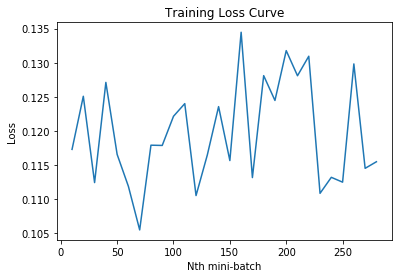

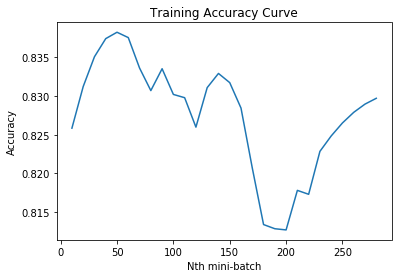

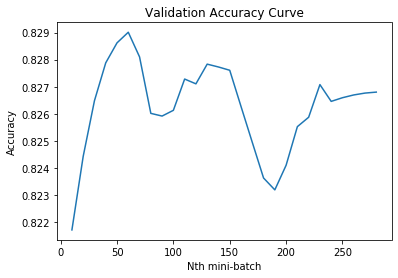

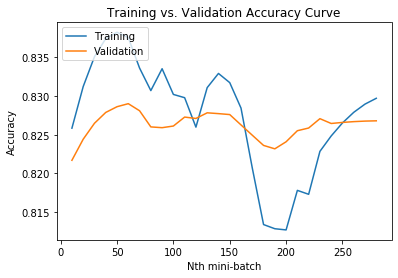

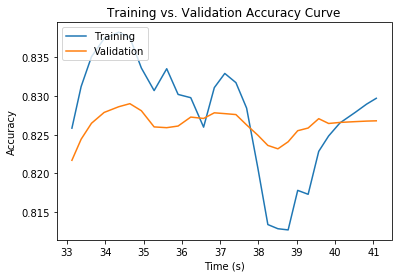

In [56]:
def main():
    #Seed for random initial weights
    torch.manual_seed(seed)

    #LOAD DATA 
    train_loader,val_loader = load_data(bs) 

    model,loss_fnc,optimizer = load_model(lr) #lr defined here

    batchlossv = 0.0 #values (accumulated per N batches)
    batchaccv = 0.0 # loss/sample (accumulated per N batches)
    
    start_time = time.time()
    for epoch in range(numepoch): #use trainloader #1 epoch, does prediction on all 17932 training samples (matrix multiply)
        nbatch = [] #batch accum
        ntime = [] 
        
        trainloss_list = [] #trainloss accum for loss (accum AVG LOSS every Nth batch)
        trainacc_list = [] #trainacc accum for trainAcc

        testacc_list = [] #testacc accum for validAcc

        batchloss_accum = 0.0 #accumed (loss/batch for N batches) v before
        batchacc_accum = 0.0 #accumed (loss/batch for N batches) v before
        
        
        for i, data in enumerate(train_loader,0): #ith batch, each sample
            #batchacc = 0.0 # loss/sample (accumulated per N batches)
            model.train() ####ADDED

            batch, label = data  #batch is size bs, each (103 col), lable is size bs, each (1 col)

            batch = Variable(batch).float()
            label = Variable(label).float()
            
            optimizer.zero_grad()
            predict = model(batch) #(bs,1) #grad_fcn = sigmoidbackward

            batchloss = loss_fnc(input = predict.squeeze(), target = label) #1 no.-> single batch's loss --> squeeze (bs,1) to (bs) 
            batchloss.backward() #compute gradients 
            optimizer.step() #modify weights and bias 


            batchloss_accum = batchloss_accum + batchloss.item() #sums loss/batch (PyTorch calculates loss over all samples in a batch to a single number)
            print('batchloss',batchloss)


            batchacc = accuracy(predict.squeeze(),label) #1 no. --> (bs,)
            batchacc_accum = batchacc_accum + batchacc
            print('batchacc',batchacc)
            

            if i % N == N-1: # print every N batches 
                model.eval() ####ADDED
                vacc = evaluate(model,val_loader) #### 
                print(epoch)
                print("avgloss/batch:", f'{batchloss_accum/N:.4f}'," avgacc/batch: ", f'{batchacc_accum/N:.4f}', " validAcc: ", f'{vacc:.4f}')
                #prints [epoch, samples gone through (aka. #batches)] avgloss/batch: # avgacc/batch: #

                #accumulate avgloss/N batches and avgacc/N batches (for plotting)
                trainloss_list.append(batchloss_accum/N)
                trainacc_list.append(batchacc_accum/N)
                testacc_list.append(vacc)                                   

                batchloss_accum = 0.0 #reset for next avg (over N batches)
                batchacc_accum = 0.0 #reset

                nbatch.append(i+1) #latest epoch 
                
                Nbatchtime = time.time() - start_time
                ntime.append(Nbatchtime)
    ######
            
    print('ntime',ntime)
    
    print('nbatch',nbatch)
    print('trainloss_list',trainloss_list)

    print('trainacc_list', trainacc_list)
    print('testacc_list',testacc_list)
    
    #Plotting 3 different activation functions accuracies together 
    #(numbers gotten from running the code for each activation function, by changing it in model.py)
    #RELU 
    trainacc_list_relu = [0.8375, 0.825, 0.8375, 0.815625, 0.83125, 0.840625, 0.8625, 0.8328125, 0.8234375, 0.8125, 0.8109375, 0.8515625, 0.8484375, 0.821875, 0.8328125, 0.809375, 0.8390625, 0.8140625, 0.8125, 0.8171875, 0.8015625, 0.8, 0.8453125, 0.8375, 0.8328125, 0.8140625, 0.83125, 0.828125]
    testacc_list_relu = [0.8238180196253345, 0.8227029438001784, 0.8204727921498662, 0.8336306868867083, 0.83028545941124, 0.8305084745762712, 0.822256913470116, 0.8289473684210527, 0.8251561106155219, 0.8256021409455843, 0.8282783229259589, 0.8267172167707404, 0.8276092774308653, 0.8280553077609277, 0.8276092774308653, 0.8264942016057092, 0.8256021409455843, 0.8249330954504906, 0.8191347011596789, 0.8251561106155219, 0.8244870651204282, 0.8278322925958965, 0.8291703835860839, 0.8258251561106156, 0.822256913470116, 0.8289473684210527, 0.8258251561106156, 0.8276092774308653]
    #TANH 
    trainacc_list_tanh = [0.828125, 0.8203125, 0.8328125, 0.8046875, 0.828125, 0.8359375, 0.853125, 0.825, 0.81875, 0.809375, 0.8234375, 0.846875, 0.8296875, 0.8171875, 0.8328125, 0.80625, 0.8390625, 0.8078125, 0.8015625, 0.8140625, 0.8109375, 0.79375, 0.8359375, 0.83125, 0.8375, 0.8, 0.8265625, 0.8234375]
    testacc_list_tanh = [0.8267172167707404, 0.8224799286351472, 0.8162355040142729, 0.8298394290811775, 0.8291703835860839, 0.8251561106155219, 0.8204727921498662, 0.8249330954504906, 0.8253791257805531, 0.8256021409455843, 0.8287243532560215, 0.8282783229259589, 0.8264942016057092, 0.8289473684210527, 0.8287243532560215, 0.8273862622658341, 0.826271186440678, 0.8231489741302409, 0.8204727921498662, 0.8280553077609277, 0.8251561106155219, 0.8267172167707404, 0.83028545941124, 0.8258251561106156, 0.8233719892952721, 0.8296164139161463, 0.8258251561106156, 0.8287243532560215]
    #SIGMOID 
    trainacc_list_sigmoid = [0.8078125, 0.803125, 0.8234375, 0.790625, 0.8328125, 0.8375, 0.834375, 0.81875, 0.8171875, 0.8109375, 0.8125, 0.828125, 0.821875, 0.8015625, 0.8234375, 0.7859375, 0.828125, 0.815625, 0.784375, 0.8046875, 0.8, 0.778125, 0.8328125, 0.8328125, 0.8234375, 0.7984375, 0.8125, 0.821875]
    testacc_list_sigmoid = [0.8184656556645852, 0.8131132917038358, 0.796164139161463, 0.8231489741302409, 0.8251561106155219, 0.8162355040142729, 0.8148974130240857, 0.8209188224799286, 0.821364852809991, 0.8206958073148974, 0.8180196253345228, 0.8198037466547725, 0.8184656556645852, 0.8180196253345228, 0.8200267618198037, 0.8206958073148974, 0.8164585191793042, 0.8068688670829617, 0.8128902765388046, 0.8128902765388046, 0.8227029438001784, 0.8198037466547725, 0.8220338983050848, 0.8231489741302409, 0.8175735950044603, 0.8249330954504906, 0.826271186440678, 0.8224799286351472]

    
    #REGULAR PLOTTING 
    #LOSS
    plt.plot(nbatch,trainloss_list,label = 'Train')
    plt.xlabel("Nth mini-batch")
    plt.ylabel("Loss") 
    plt.title("Training Loss Curve")
    plt.show()
    
    #ACCURACY VS. BATCH 
    plt.plot(nbatch,savgol_filter(trainacc_list,11,2),label = 'Train')
    plt.xlabel("Nth mini-batch")
    plt.ylabel("Accuracy") 
    plt.title("Training Accuracy Curve")
    plt.show()
    
    plt.plot(nbatch,savgol_filter(testacc_list,9,2),label = 'Validation')
    plt.xlabel("Nth mini-batch")
    plt.ylabel("Accuracy") 
    plt.title("Validation Accuracy Curve")
    plt.show()
    
    #TRAIN/VALID ACCURACY VS. BATCH on same graph 
    plt.plot(nbatch,savgol_filter(trainacc_list,11,2),label = 'Train')
    plt.plot(nbatch,savgol_filter(testacc_list,9,2),label = 'Validation')
    plt.xlabel("Nth mini-batch")
    plt.ylabel("Accuracy") 
    plt.title("Training vs. Validation Accuracy Curve")
    plt.legend(['Training', 'Validation'], loc='upper left')
    plt.show()
    
    #ACCURACY VS. TIME 
    plt.plot(ntime,savgol_filter(trainacc_list,11,2),label = 'Train')
    plt.plot(ntime,savgol_filter(testacc_list,9,2),label = 'Validation')
    plt.xlabel("Time (s)")
    plt.ylabel("Accuracy") 
    plt.title("Training vs. Validation Accuracy Curve")
    plt.legend(['Training', 'Validation'], loc='upper left')
    plt.show()
    
        
    #Plotting 3 different activation function accuracies together (if neccessary) #
    '''plt.plot(nbatch,savgol_filter(trainacc_list_relu,11,2),label = 'TrainReLU')
    plt.plot(nbatch,savgol_filter(testacc_list_relu,9,2),label = 'ValidationReLU')
    
    plt.plot(nbatch,savgol_filter(trainacc_list_tanh,11,2),label = 'TrainTanh')
    plt.plot(nbatch,savgol_filter(testacc_list_tanh,9,2),label = 'ValidationTanh')
    
    plt.plot(nbatch,savgol_filter(trainacc_list_sigmoid,11,2),label = 'TrainSigmoid')
    plt.plot(nbatch,savgol_filter(testacc_list_sigmoid,9,2),label = 'ValidationSigmoid')
    
    
    plt.xlabel("Nth mini-batch")
    plt.ylabel("Accuracy") 
    plt.title("Training vs. Validation Accuracy Curve")
    plt.legend(['TrainReLU', 'ValidationReLU', 'TrainTanh', 'ValidationTanh', 'TrainSigmoid','ValidationSigmoid'], loc='upper left')
    plt.show()'''
    


if __name__ == "__main__":
    main()